In [45]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns 
import kagglehub
from kagglehub import KaggleDatasetAdapter

sns.set(style="darkgrid")

In [46]:
file_path = "PremierLeague.csv"

# Load the data from Kaggle
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ajaxianazarenka/premier-league",
  file_path,
)

In [47]:
# Create a dataframe for each team's home games
home = df.rename(columns={
    "HomeTeam": "Team",
    "AwayTeam": "Opponent",
    "FullTimeHomeTeamGoals": "GF",
    "FullTimeAwayTeamGoals": "GA"
})[["MatchID", "Season", "MatchWeek", "Team", "Opponent", "GF", "GA"]]

# Create a dataframe for each team's away games
away = df.rename(columns={
    "AwayTeam": "Team",
    "HomeTeam": "Opponent",
    "FullTimeAwayTeamGoals": "GF",
    "FullTimeHomeTeamGoals": "GA"
})[["MatchID", "Season", "MatchWeek", "Team", "Opponent", "GF", "GA"]]

# Combine home and away results so you have every team's every game accounted for
allMatches = pd.concat([home, away])

# Calculate goal difference and create a new dataframe for season-wide totals
allMatches["GD"] = allMatches["GF"] - allMatches["GA"]
teamResults = allMatches.groupby(["Season", "Team"], as_index=False).agg(
    GF = ("GF", "sum"),
    GA = ("GA", "sum"),
    G = ("MatchWeek", "count"),
    W = ("GD", lambda x: (x > 0).sum()),
    D = ("GD", lambda x: (x == 0).sum()),
)

# Calculate the total points for each team
teamResults["P"] = (3 * teamResults["W"] + 1 * teamResults["D"])
# Calculate the ratio of points out of total points available
teamResults["PR"] = (3 * teamResults["W"] + 1 * teamResults["D"]) / (3 * teamResults["G"])
# Calculate the ratio of goals and then use log to smooth into a linear relationship
teamResults["GR"] = np.log((teamResults["GF"] / teamResults["GA"]))

In [48]:
# Creates a dataframe matrix with columns of constant 1 (to represent an eventual alpha constant), and the goal ratio
X = sm.add_constant(teamResults["GR"])
# A series of the points ratio
y = teamResults["PR"]

# Finds the fit results of a binomial GLM using X and y as inputs
fit = sm.GLM(
    y, X,
    family=sm.families.Binomial(),
).fit() 

# Uses the coefficient of the constant column as alpha
alpha = fit.params["const"]
# Uses the coefficient of the GR column as k
k = fit.params["GR"]
# Finds e^alpha to use as a coefficient in the Pythagorean equation
c = np.exp(alpha) 

print(fit.summary())
print("alpha =", alpha)
print("k =", k)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     PR   No. Observations:                  644
Model:                            GLM   Df Residuals:                      642
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -276.21
Date:                Tue, 27 Jan 2026   Deviance:                       4.4971
Time:                        00:05:39   Pearson chi2:                     4.46
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07805
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1682      0.082     -2.041      0.0

In [49]:
teamResults["xP"] = (c * teamResults["GF"]**k / (c * teamResults["GF"]**k + teamResults["GA"]**k)) * 3 * teamResults["G"]

cleanResults = teamResults[["Season", "Team", "P", "xP"]]

print(cleanResults.tail(20))

        Season            Team   P         xP
624  2024-2025         Arsenal  74  75.859201
625  2024-2025     Aston Villa  66  56.639393
626  2024-2025     Bournemouth  56  60.191825
627  2024-2025       Brentford  56  57.259196
628  2024-2025        Brighton  61  56.070870
629  2024-2025         Chelsea  69  65.839615
630  2024-2025  Crystal Palace  53  52.218435
631  2024-2025         Everton  48  50.630778
632  2024-2025          Fulham  54  52.218435
633  2024-2025         Ipswich  22  27.134939
634  2024-2025       Leicester  25  25.607818
635  2024-2025       Liverpool  84  76.866020
636  2024-2025        Man City  71  68.996173
637  2024-2025      Man United  42  45.317681
638  2024-2025       Newcastle  66  64.884626
639  2024-2025   Nott'm Forest  65  60.191825
640  2024-2025     Southampton  12  18.918346
641  2024-2025       Tottenham  38  51.688345
642  2024-2025        West Ham  43  42.263145
643  2024-2025          Wolves  42  43.993215


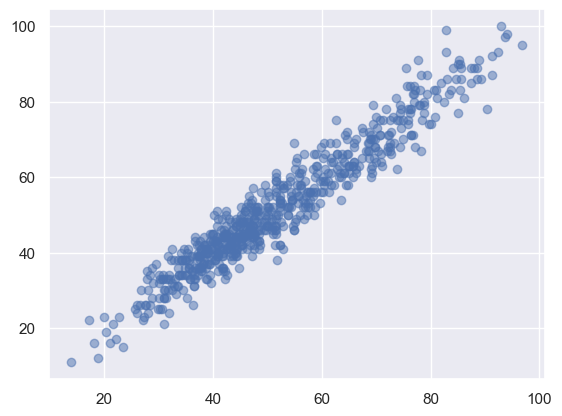

In [51]:
x = cleanResults["xP"]
y = cleanResults["P"]

plt.scatter(x, y, alpha=0.5)
plt.show()